## Imports

In [1]:
import pandas as pd
import numpy as np
import importlib, os, math, datetime
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
from ir_crosslingual.utils import paths
importlib.reload(paths)

from ir_crosslingual.features import text_based
importlib.reload(text_based)

from ir_crosslingual.features import vector_based
importlib.reload(vector_based)

from ir_crosslingual.supervised_classification import sup_model
importlib.reload(sup_model)

from ir_crosslingual.sentences import sentences
importlib.reload(sentences)

<module 'ir_crosslingual.sentences.sentences' from '/Users/i500969/Desktop/Admin/Uni-Mannheim/02_Courses/2020_FSS/Information-Retrieval/03_Project/03_Implementation/03_Feature-Selection/ir-crosslingual/ir_crosslingual/sentences/sentences.py'>

## Load data

In [3]:
sens, train_data, test_collection, features = sentences.Sentences.load_from_file(f'{paths.data_path}extracted-data/training_data_v0.0.pkl', f'{paths.data_path}extracted-data/test_collection_v0.0.pkl')


Learn projection matrix for en-de
Found 13700 valid translation pairs in expert dictionary.
977 other pairs contained at least one unknown word (0 in source language, 977 in target language).
Resulting subspace dimension: (13700, 300)
Resulting subspace dimension: (13700, 300)
Learn projection matrix for de-en
Found 10604 valid translation pairs in expert dictionary.
262 other pairs contained at least one unknown word (0 in source language, 262 in target language).
Resulting subspace dimension: (10604, 300)
Resulting subspace dimension: (10604, 300)


## Feature selection

In [4]:
# features = list(text_based.FEATURES.keys()) + list(vector_based.FEATURES.keys())
# features = 'diff_num_words diff_num_punctuation diff_occ_question_mark diff_occ_exclamation_mark cosine_similarity'.split()
label = 'translation'

In [5]:
rfecv = RFECV(estimator=LogisticRegression(), step=1, 
              cv=StratifiedKFold(n_splits=5, random_state=42), scoring='precision')

In [6]:
start = datetime.datetime.now()
rfecv.fit(train_data[features], train_data[label])
stop = datetime.datetime.now()

In [7]:
f'Computation time fitting the feature selection: {stop-start}'

'Computation time fitting the feature selection: 0:00:10.196206'

In [8]:
f'Optimal number of features: {rfecv.n_features_}'

Optimal number of features: 3


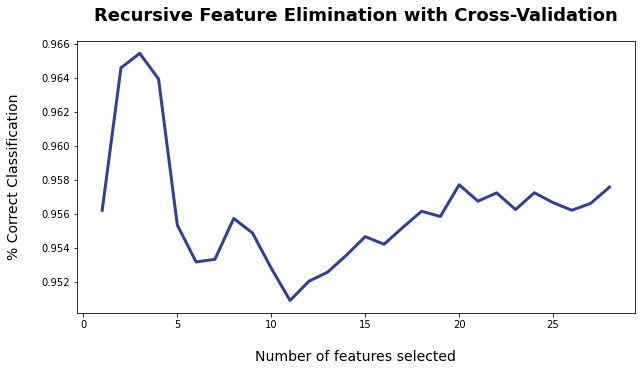

In [9]:
plt.figure(figsize=(10, 5))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

In [10]:
features_drop = list(train_data[features].columns[np.where(rfecv.support_ == False)[0]])
features_keep = list(train_data[features].columns[np.where(rfecv.support_ == True)[0]])

In [29]:
print('Keep the following features:\n## {}'.format(features_keep))
print('Drop the following features:\n## {}'.format(features_drop))

Keep the following features:
## ['diff_occ_question_mark', 'norm_diff_translated_words', 'cosine_similarity']
Drop the following features:
## ['diff_num_words', 'diff_num_punctuation', 'diff_occ_exclamation_mark', 'diff_num_noun', 'diff_num_verb', 'diff_num_adverb', 'diff_num_adjective', 'diff_num_wh', 'diff_num_pronoun', 'rel_diff_num_words', 'rel_diff_num_punctuation', 'rel_diff_num_noun', 'rel_diff_num_verb', 'rel_diff_num_adverb', 'rel_diff_num_adjective', 'rel_diff_num_wh', 'rel_diff_num_pronoun', 'norm_diff_num_words', 'norm_diff_num_punctuation', 'norm_diff_num_noun', 'norm_diff_num_verb', 'norm_diff_num_adverb', 'norm_diff_num_adjective', 'norm_diff_num_wh', 'norm_diff_num_pronoun']


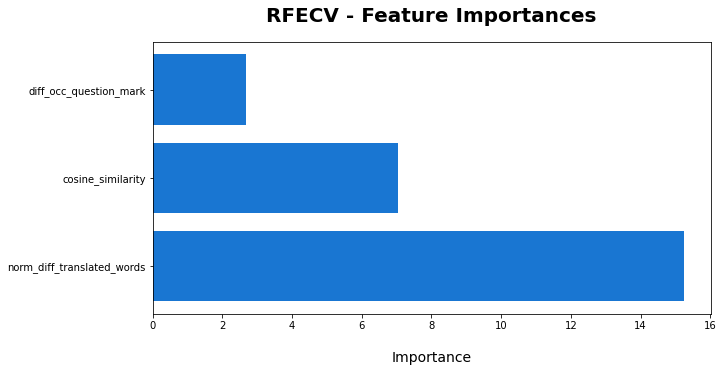

In [12]:
dset = pd.DataFrame()
dset['attr'] = features_keep
dset['importance'] = rfecv.estimator_.coef_.tolist()[0]

dset = dset.sort_values(by='importance', ascending=False)


plt.figure(figsize=(10,5))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

## Evaluate feature selection

In [22]:
logisticRegr = LogisticRegression()
logisticRegr.fit(train_data[features_keep], train_data[label])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [23]:
# Evaluation on test collection
sup = sup_model.SupModel()
sup.evaluate_boolean(logisticRegr, sens, features_keep)
print('Accuracy: {}'.format(sup.accuracy))
print('Precision: {}'.format(sup.precision))
print('Recall: {}'.format(sup.recall))
print('F1: {}'.format(sup.f1))

print('MAP: {}'.format(sup.compute_map(logisticRegr, sens, features_keep)))

Accuracy: 0.9572088353413655
Precision: 0.022048690858980247
Recall: 0.96
F1: 0.04310731926358329
MAP: 0.872742127153892
